## Bloomblerg Japan Hackathon 2018/09/01

The goal is to predict cryptocurrency price in the future. If possible, predict the timing to buy and sell.
Our team decided to use ensemble of different models, semantic text for hype in twitter discussion, technical analysis of historical price and influencse of other finacial markets like stock market and gold market, etc.

This notebook tries to implement the last idea, uses recent Bitcoin price, trade volume, NASDAQ index, OIL ETF index, GOLD ETF index and companies like BLK and BTCS as inputs to predict the BTC/USD price of the next day, given limited amount of time in this hackathon. Of course, the model can be extended to include more factors.

In [1]:
from math import sqrt
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM

/Users/sushi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Get data from 2017/01/01 to 2017/11/09
Our team want to use data from 2017/09/01 to 2017/11/09 as testing data.

In [37]:
import glob
files = glob.glob("data/*.csv")
flie_list = []
for f in files:
    _df = pd.read_csv(f, index_col=None, header=0)
    flie_list.append(_df[['Open','Volume']])
df = pd.concat(flie_list, axis=1, sort=False)
index_names = ['BTC','BTC_V','BTCS','BTCS_V','NASDAQ','NASDAQ_V','OIL','OIL_V','GOLD','GOLD_V','BLK','BLK_V']
df.columns= index_names
df.head()

,BTC,BTC_V,BTCS,BTCS_V,NASDAQ,NASDAQ_V,OIL,OIL_V,GOLD,GOLD_V,BLK,BLK_V
0,1017.049988,56085870,0.12,119193200,5425.620117,1886200000,8.94,14900,8.11,162300,384.619995,743900
1,1033.300049,170584623,0.24,77647900,5440.910156,1883360000,8.46,5100,8.64,155200,384.649994,680800
2,1135.410034,244839289,0.24,27760600,5474.390137,1792610000,8.85,9100,8.74,285100,384.980011,468400
3,989.349976,179160668,0.18,20267000,5499.080078,1710770000,8.98,12600,8.96,239800,383.570007,453400
4,900.859985,55963281,0.18,9168200,5527.580078,1885500000,8.94,4700,9.01,371300,384.350006,505300


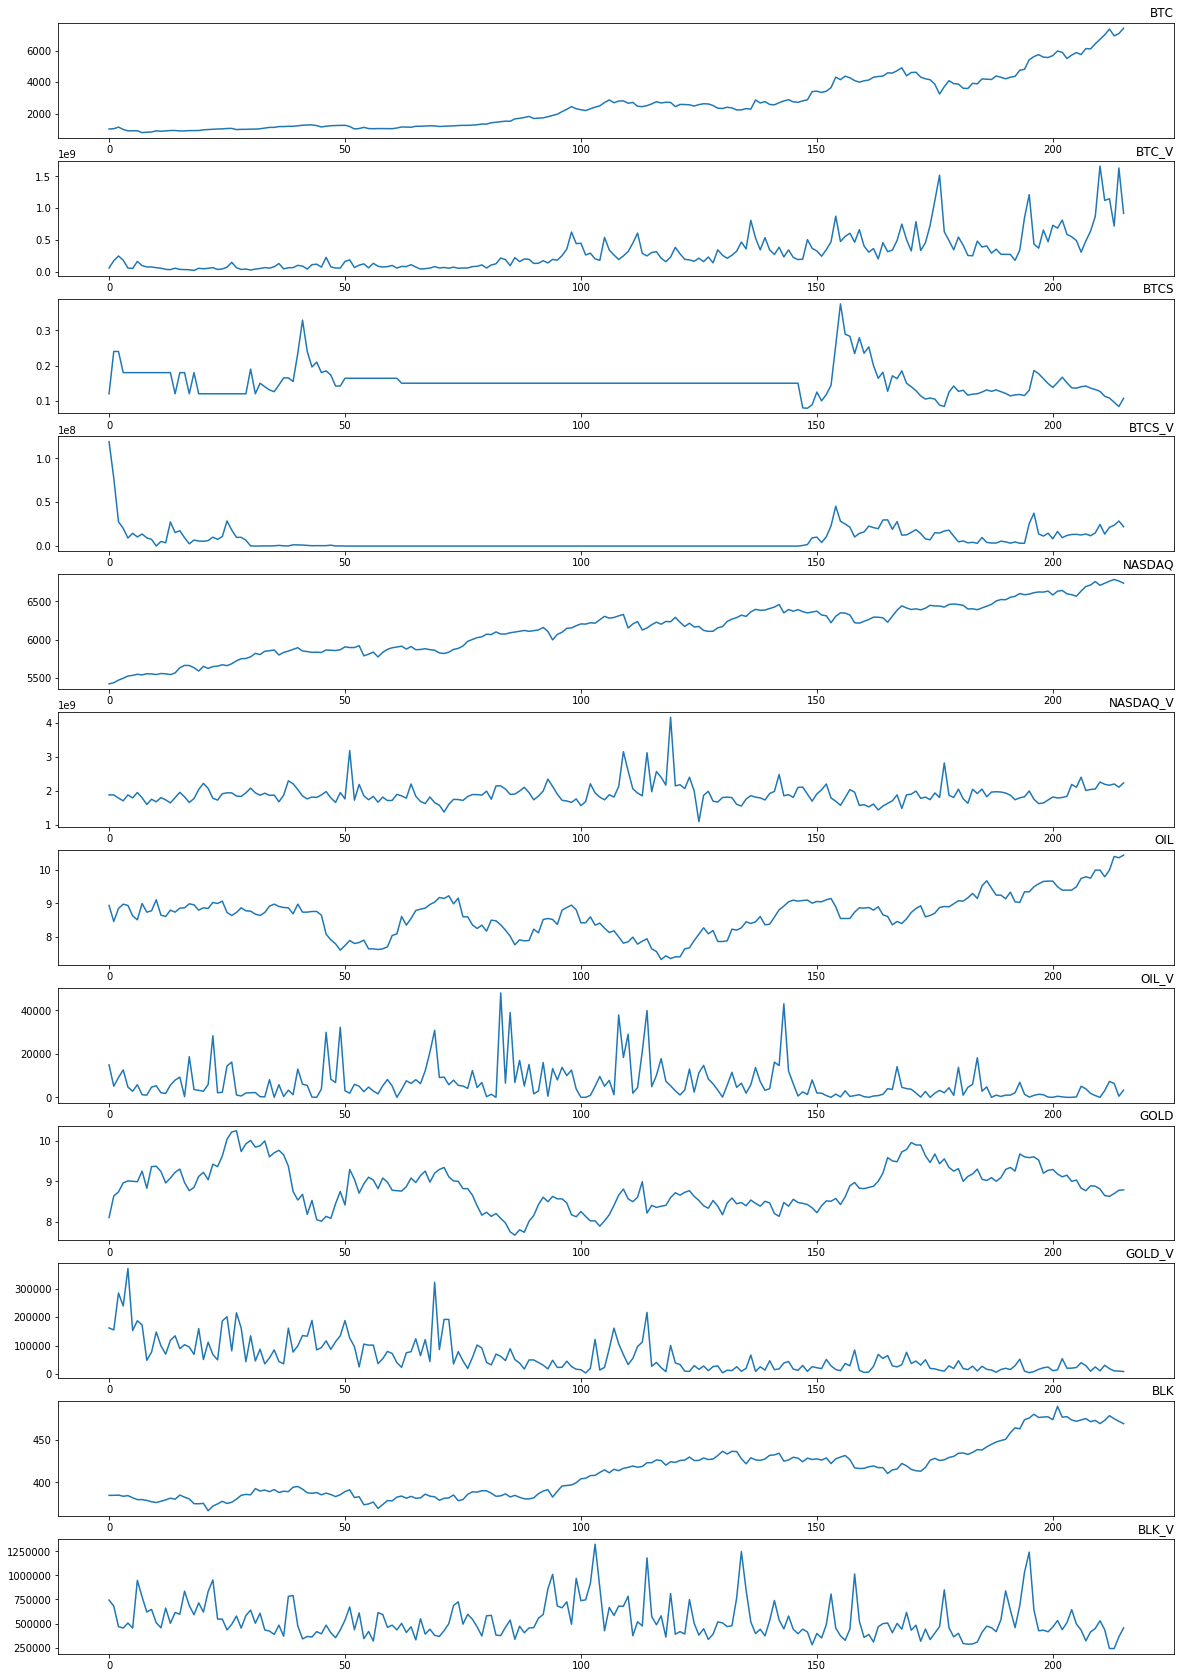

In [119]:
number_of_features = 12
plt.figure(figsize=(20,30))
for i in range(0, number_of_features):
    plt.subplot(number_of_features, 1, i+1)
    plt.plot(df.values[:, i])
    plt.title(df.columns[i], loc='right')
plt.show()

In [120]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df.values)
scaled_df = pd.DataFrame(scaled, columns=index_names)
scaled_df.head()

,BTC,BTC_V,BTCS,BTCS_V,NASDAQ,NASDAQ_V,OIL,OIL_V,GOLD,GOLD_V,BLK,BLK_V
0,0.034783,0.023385,0.138514,1.000000,0.000000,0.257144,0.517572,0.310417,0.167969,0.431138,0.147316,0.464612
1,0.037224,0.092965,0.543919,0.651446,0.011244,0.256216,0.364217,0.106250,0.375000,0.411813,0.147559,0.406386
2,0.052558,0.138089,0.543919,0.232904,0.035865,0.226551,0.488818,0.189583,0.414062,0.765378,0.150235,0.210390
3,0.030624,0.098177,0.341216,0.170035,0.054022,0.199798,0.530351,0.262500,0.500000,0.642079,0.138803,0.196549
4,0.017335,0.023311,0.341216,0.076919,0.074980,0.256915,0.517572,0.097917,0.519531,1.000000,0.145127,0.244440


In [125]:
#goal: use previous 10 steps to predict a new step
number_of_steps = 10
stepped_df_list = [scaled_df,]
for i in range(1, number_of_steps+1):
    one_step_df = scaled_df.shift(-i)
    one_step_df.columns = ["{}+{}d".format(x, i) for x in scaled_df.columns]
    stepped_df_list.append(one_step_df)
stepped_df = pd.concat(stepped_df_list, axis=1)
#drop first number_of_steps of rows
stepped_df = stepped_df.iloc[:-number_of_steps, :]
stepped_df.head()

,BTC,BTC_V,BTCS,BTCS_V,NASDAQ,NASDAQ_V,OIL,OIL_V,GOLD,GOLD_V,...,BTCS+10d,BTCS_V+10d,NASDAQ+10d,NASDAQ_V+10d,OIL+10d,OIL_V+10d,GOLD+10d,GOLD_V+10d,BLK+10d,BLK_V+10d
0,0.034783,0.023385,0.138514,1.000000,0.000000,0.257144,0.517572,0.310417,0.167969,0.431138,...,0.341216,0.000680,0.089218,0.190825,0.571885,0.110417,0.660156,0.392216,0.078725,0.247393
1,0.037224,0.092965,0.543919,0.651446,0.011244,0.256216,0.364217,0.106250,0.375000,0.411813,...,0.341216,0.044423,0.099270,0.230833,0.424920,0.043750,0.609375,0.259662,0.090968,0.199040
2,0.052558,0.138089,0.543919,0.232904,0.035865,0.226551,0.488818,0.189583,0.414062,0.765378,...,0.341216,0.031503,0.096520,0.209458,0.412141,0.037500,0.500000,0.180185,0.104021,0.388023
3,0.030624,0.098177,0.341216,0.170035,0.054022,0.199798,0.530351,0.262500,0.500000,0.642079,...,0.341216,0.230885,0.088997,0.180028,0.472843,0.116667,0.546875,0.312466,0.120723,0.242133
4,0.017335,0.023311,0.341216,0.076919,0.074980,0.256915,0.517572,0.097917,0.519531,1.000000,...,0.138514,0.129261,0.104904,0.230722,0.453674,0.164583,0.601562,0.356015,0.110670,0.345760


In [134]:
#train test split
#train period 2017/01/01 to 2017/08/31, data length = 168
#test period 2017/09/01 to 2017/11/10
values = stepped_df.values
train = values[:168, :]
test = values[168:, :]
train_X, train_y = train[:, :-number_of_features], train[:, -number_of_features]
test_X, test_y = test[:, :-number_of_features], test[:, -number_of_features]
# reshape to (samples, steps, features)
train_X = train_X.reshape((train_X.shape[0], number_of_steps, number_of_features))
test_X = test_X.reshape((test_X.shape[0], number_of_steps, number_of_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(168, 10, 12) (168,) (38, 10, 12) (38,)


Train on 168 samples, validate on 38 samples
Epoch 1/200
168/168 [==============================] - 6s 35ms/step - loss: 0.1013 - val_loss: 0.1401
Epoch 2/200
168/168 [==============================] - 0s 1ms/step - loss: 0.1318 - val_loss: 0.2628
Epoch 3/200
168/168 [==============================] - 0s 1ms/step - loss: 0.0535 - val_loss: 0.0799
Epoch 4/200
168/168 [==============================] - 0s 1ms/step - loss: 0.0692 - val_loss: 0.1099
Epoch 5/200
168/168 [==============================] - 0s 1ms/step - loss: 0.0372 - val_loss: 0.0597
Epoch 6/200
168/168 [==============================] - 0s 1ms/step - loss: 0.0405 - val_loss: 0.0611
Epoch 7/200
168/168 [==============================] - 0s 2ms/step - loss: 0.0437 - val_loss: 0.0646
Epoch 8/200
168/168 [==============================] - ETA: 0s - loss: 0.071 - 0s 1ms/step - loss: 0.0722 - val_loss: 0.1314
Epoch 9/200
168/168 [==============================] - 0s 1ms/step - loss: 0.0267 - val_loss: 0.0526
Epoch 10/200
168/168 

168/168 [==============================] - 0s 1ms/step - loss: 0.0220 - val_loss: 0.0488
Epoch 81/200
168/168 [==============================] - 0s 1ms/step - loss: 0.0315 - val_loss: 0.0732
Epoch 82/200
168/168 [==============================] - 0s 1ms/step - loss: 0.0142 - val_loss: 0.0592
Epoch 83/200
168/168 [==============================] - 0s 1ms/step - loss: 0.0168 - val_loss: 0.0541
Epoch 84/200
168/168 [==============================] - 0s 1ms/step - loss: 0.0272 - val_loss: 0.0639
Epoch 85/200
168/168 [==============================] - 0s 1ms/step - loss: 0.0199 - val_loss: 0.0792
Epoch 86/200
168/168 [==============================] - 0s 1ms/step - loss: 0.0347 - val_loss: 0.0392
Epoch 87/200
168/168 [==============================] - 0s 1ms/step - loss: 0.0199 - val_loss: 0.0542
Epoch 88/200
168/168 [==============================] - 0s 1ms/step - loss: 0.0330 - val_loss: 0.0933
Epoch 89/200
168/168 [==============================] - 0s 1ms/step - loss: 0.0178 - val_loss: 

Epoch 160/200
168/168 [==============================] - 0s 1ms/step - loss: 0.0182 - val_loss: 0.0722
Epoch 161/200
168/168 [==============================] - 0s 1ms/step - loss: 0.0231 - val_loss: 0.0513
Epoch 162/200
168/168 [==============================] - 0s 1ms/step - loss: 0.0157 - val_loss: 0.0563
Epoch 163/200
168/168 [==============================] - 0s 1ms/step - loss: 0.0266 - val_loss: 0.0752
Epoch 164/200
168/168 [==============================] - 0s 1ms/step - loss: 0.0149 - val_loss: 0.0507
Epoch 165/200
168/168 [==============================] - 0s 1ms/step - loss: 0.0160 - val_loss: 0.0520
Epoch 166/200
168/168 [==============================] - 0s 1ms/step - loss: 0.0162 - val_loss: 0.0624
Epoch 167/200
168/168 [==============================] - 0s 1ms/step - loss: 0.0156 - val_loss: 0.0554
Epoch 168/200
168/168 [==============================] - 0s 1ms/step - loss: 0.0135 - val_loss: 0.0477
Epoch 169/200
168/168 [==============================] - 0s 1ms/step - lo

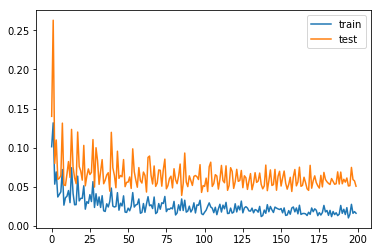

In [140]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_y, epochs=200, batch_size=10, validation_data=(test_X, test_y), shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [141]:
# predict
y_pred = model.predict(test_X)
# mse
print("Prediction MSE: {}".format(mean_squared_error(test_y, y_pred)))
orig_shape_test_X = test_X.reshape((test_X.shape[0], number_of_steps*number_of_features))
# print(pd.DataFrame(orig_test_X[:, -(number_of_columns-1):]).head())
orig_shape_test_y = test_y.reshape((len(test_y), 1))
def inverse_scale(y):
    y = np.concatenate((y, orig_shape_test_X[:, -(number_of_features-1):]), axis=1)
    y = scaler.inverse_transform(y)
    return y[:,0]
iy = inverse_scale(orig_shape_test_y)
# inverse scale for prediction values
iy_pred = inverse_scale(y_pred)
# invert scaling for actual
# calculate RMSE
print("Original Price Prediction MSE: {}".format(mean_squared_error(iy, iy_pred)))

Prediction MSE: 0.0039184521205519
Original Price Prediction MSE: 173749.44523348333


In [142]:
pred = pd.DataFrame({'Predict':iy_pred, 'Actual BTC Price':iy})
pred

,Predict,Actual BTC Price
0,3939.284931,4100.279785
1,4323.354416,3907.959961
2,4267.765748,3882.159912
3,4073.550916,3617.270020
4,3862.218048,3600.830078
5,3706.674085,3932.830078
6,3741.601165,3892.699951
7,3735.154069,4212.200195
8,3893.395584,4195.649902
9,3991.438600,4172.790039


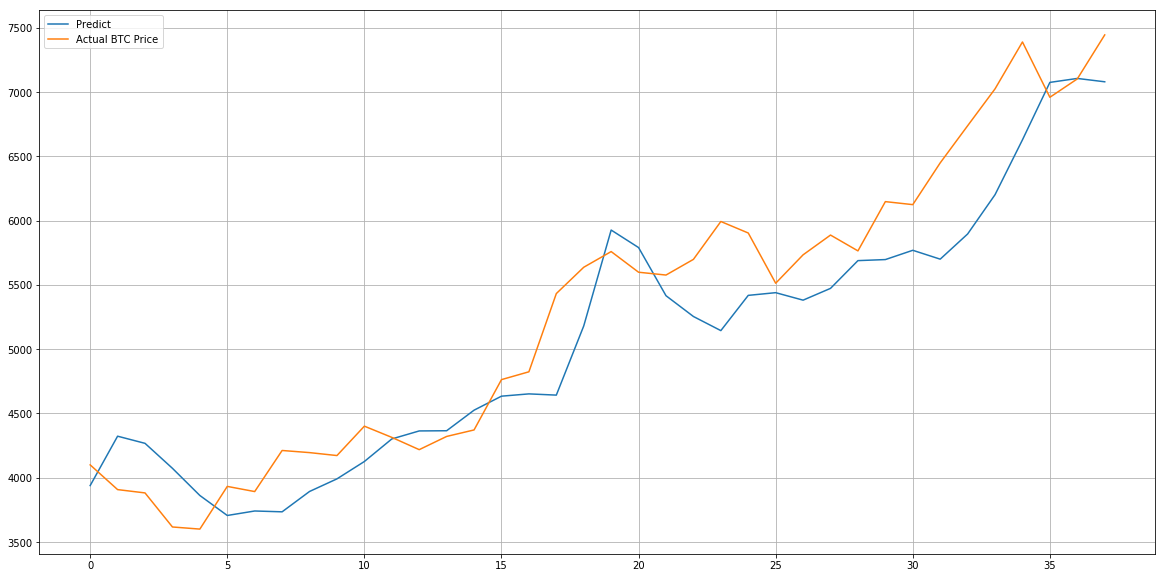

In [143]:
import matplotlib.pyplot as plt
# df.plot(y=['BTC'])
pred.plot(y=["Predict", "Actual BTC Price"], figsize=(20,10), grid=True)
plt.legend(loc='upper left')
plt.show()